In [4]:
import rebound, numpy as np, matplotlib as mpl
#mpl.use('Agg') # found here:https://stackoverflow.com/questions/4931376/generating-matplotlib-graphs-without-a-running-x-server
import matplotlib.pyplot as plt, time as tiempo, math, sys

import subprocess 
def ding(): 
    """
    This is sometimes added to the end of code that takes a long time to run,
    so that I know when it is completed.
    It requires an mp3 file named "ding.mp3" in the same directory as this file.
    """
    subprocess.call(["afplay","ding.mp3"])

sim = rebound.Simulation()
tau = 2*np.pi

In [5]:
def ttor(R0 = 5e-4): #two to one resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 5**(1/3)*0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=2**(2/3), f=np.pi, r=R0) 
    return sim

def tttr(R0 = 5e-4): #two to three resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=2**(2/3), r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=3**(2/3), f=np.pi, r=R0) 
    return sim

def nor(R0 = 5e-4): #no resonance (initially at least)
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    sim.add(m=1) #creates a star of mass 1
    #R0 = .02
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=1.8, f=np.pi, r=R0) #use .1 mass to show the planets having a large effect on each other
    return sim
    
def resonance_counter(data, base = 1): # data should be realtive x values or y values
    innerplanetcount = 0
    outerplanetcount = 0
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        if x[0] < 0 and data[i+1][0] > 0:
            innerplanetcount += 1
        if x[1] < 0 and data[i+1][1] > 0:
            outerplanetcount += 1
    R = innerplanetcount/outerplanetcount
    print(R)
    R = R*base
    if R == int(R):
        R = int(R)
    print("The outer planet revolved", outerplanetcount, "times.")
    print("The inner planet revolved", innerplanetcount, "times.")
    print("They are in a {}:{} resonance.".format(base, R))
     
def rand_powerlaw(slope, min_v, max_v): #some distribution functions
    #https://rebound.readthedocs.io/en/latest/ipython/PrimordialEarth.html
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))
def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum
def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

def quickplot(sim): #this uses matplotlib to plot the orbit, instead of rebound
    coords = np.zeros((2,sim.N))
    for i in range(sim.N):
        coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.scatter(coords[0],coords[1])
    for i in range(sim.N_active):
        ax.scatter(sim.particles[i].x,sim.particles[i].y); # Planet
        
def my_merge(sim_pointer, collided_particles_index):
    
    #https://rebound.readthedocs.io/en/latest/ipython/User_Defined_Collision_Resolve.html
    #or
    #https://rebound.readthedocs.io/en/latest/ipython_examples/User_Defined_Collision_Resolve/
    
    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i1 = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.
    j1 = collided_particles_index.p2
    
    if ps[i1]==0 and ps[j1]==0:
        return 0
    else:
        if ps[i1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=j1
            l=i1
            destroyi1=True
        if ps[j1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=i1
            l=j1
            destroyi1=False
            
        '''fig, ax = rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
        ax.set_title("Merging particle {} into {}".format(j, i))
        ax.text(ps[k].x, ps[k].y, "1");
        ax.text(ps[l].x, ps[l].y, "2")'''
        # So we plot the scenario exactly at the timestep that the collision function is triggered
        
        #print("merging particle", k,'into particle', l) #use this to know when collisions occur
        
        #particle_mass = Mtot_disk/N_pl
        particle_mass=1e-5
        particle_radius = 1e-5
        # Merging Logic
        total_mass = ps[k].m + particle_mass
        #merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

        # merged radius assuming a uniform density
        merged_radius = (ps[k].r**3 + particle_radius**3)**(1/3)

        #ps[k] = merged_planet   # update p1's state vector (mass and radius will need corrections)
        ps[k].m = total_mass    # update to total mass
        ps[k].r = merged_radius # update to joined radius
        
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1 #after adding mass
        #to a particle, we must recalculate Jacobi coordinates in order to recieve
        #physical values. Note that this code should be commented out if safemode is on.
        
        if destroyi1:
            return 1 #destroys p1, which is the particle w/o mass
        else:
            return 2 #destroys p2, which is the particle w/o mass
     
    
def masslist_txt(masslist,filepath,sim = None, write_type = 'a'):
    """
    Saves the masslists into a formatted txt file.
    """
    
    def avg(lst):
        sum = 0
        for i in lst:
            sum += i
        return sum / len(lst)

    masslistcopy = masslist.copy() # Don't want to edit the original data
    percentlist = list()
    message = ''
    message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        percentlist.append(percentdif)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'   
    message+= "\nAverage percent difference= {}.\n\n".format(avg(percentlist))
    with open(filepath,write_type) as file:
        file.write(sim+'\n')
        file.write(message)
        
def masslist_txt_append(masslist, filepath,sim = None,write_type = 'a', **kwargs):
    """
    Saves the masslists into a formatted txt file. This is similar to masslist_txt except 
    it lends itself better to appending. It is meant for simulations ran entirely separately.
    """
    
    def avg(listt):
        sum = 0
        for i in listt:
            sum += i
        return sum / len(listt)
    
    masslistcopy = masslist.copy() # Don't want to edit the original data
    message = ''
    if kwargs.get('first'):
        write_type = "w"
        message += sim+'\n'
        message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        #data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'
    with open(filepath,write_type) as file:
        file.write(message)
    if kwargs.get('last'):
        with open(filepath, "a") as file:
            file.write("\nAverage percent difference: {}"
                       .format(averagePercent(filepath)))
            file.write("\n"+"#"*40)
        
def masslist_read(filePath):
    """
    Inverse of masslist_txt()
    """
    with open(filePath,'r') as datafile:
        contents = datafile.read()
    contents = contents.split()
    finalList = []
    for index,value in enumerate(contents):
        try:
            value = float(value)
            finalList.append(value)
        except:
            pass
    return finalList

def avg(listt):
    sum = 0
    for i in listt:
        sum += i
    return sum / len(listt)
def averagePercent(filePath):
    dataList = masslist_read(filePath)
    percentList = []
    for i in range(2,len(dataList),4):
        percentList.append(dataList[i])
    return avg(percentList)

def saveFigs(addOn = "", seed = 0):
    """
    This saves several types of graphs into a folder corresponsing to the seed.
    Optional ability to add on to the name of a file easily.
    NOTE: Depending on the stepnumber, some of these graphs may contain useless data,
    because for some data types the stepnumber needs to be very high.
    """
    plt.clf() # clears any graphs
    quickplot(sim)
    plt.savefig("Figures/"+str(seed)+"/quickplot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim,slices=0.3,color=True)
    plt.savefig("Figures/"+str(seed)+"/reboundPlot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim, slices = .3, color = True, lw = 1, plotparticles = [1,2])
    plt.savefig("Figures/"+str(seed)+"/reboundPlotOnlyPlanets"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, eccs)
    plt.title('Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/Eccentricity"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, relative_x_value)
    plt.title('X Value From Star Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('X Value (AU)')
    plt.savefig("Figures/"+str(seed)+"/relativeXValue"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, masses)
    plt.title('Mass of Planets Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Mass (Solar Masses)')
    plt.savefig("Figures/"+str(seed)+"/masses"+addOn+".pdf")
    
    plt.clf()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Planet Positions')
    axs[0].plot(list(position1[:,0]), list(position1[:,1]),'o')
    axs[1].plot(list(position2[:,0]), list(position2[:,1]),'o')
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')
    plt.savefig("Figures/"+str(seed)+"/scatterPlotPositions"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, interplanetdistance)
    plt.title('Interplanetary Distance Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Distance (AU)')
    plt.savefig("Figures/"+str(seed)+"/interplanetaryDistance"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, particleNumber)
    plt.title('sim.N over time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('sim.N (AU)')
    plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")

In [64]:
def generatettor(simulation = ttor,seed = None, asteroidnumber = 1000):  
    sim = simulation()
    sim.N_active = sim.N

    sim.integrator = "ias15"
#     sim.integrator = "mercurius"
    #sim.ri_mercurius.hillfac = 3
    #sim.ri_ias15.min_dt = 0 # stes the minimum dt, default is 0. This should be specified on mercurius as well.
    #sim.integrator = "whfast"
    #sim.ri_whfast.corrector = 0 #zero order corrector for better speed
    #sim.ri_whfast.safe_mode = 0 #turns off safemode, *substantial* speed boost
    #sim.dt = 0.001*2*np.pi #mutiple by 2pi if in units such that G=1
    sim.testparticle_type = 0
    #sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = my_merge # a function that I made
    sim.collision_resolve_keep_sorted = 1
    sim.boundary = "open"
    boxsize = 100
    sim.configure_box(boxsize)
    sim.track_energy_offset = 1

    N_pl = asteroidnumber                # Number of planetesimals
    Mtot_disk = 10*sim.particles[1].m    # Total mass of planetesimal disk
    m_pl = 0 #Mtot_disk / float(N_pl)    # Mass of each planetesimal
    r_pl = 2e-9 

    #seed = 0
    #46 is my most frequently used seed
    np.random.seed(seed) # by setting a seed we will reproduce the same simulation every time
    while sim.N < (N_pl + sim.N_active):
        #a = rand_powerlaw(0, 0.1, 3) 
        a = rand_uniform(.6,2.9)
        #e = rand_rayleigh(0.01) by default is 0
        e=0
        #inc = rand_rayleigh(0.005)
        inc=0
        f = rand_uniform(-np.pi,np.pi)
        p = rebound.Particle(simulation=sim,primary=sim.particles[0], r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=0, f=f)
        # Only add planetesimal if it's far away from the planet
        d1 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[1].xyz))
        d2 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[2].xyz))
        d = min(d1,d2)
        if d>5e-4:
            sim.add(p)
    
    # Hash Creation
    ps = sim.particles
    ps[0].hash = "star"
    ps[1].hash = "innerPlanet"
    ps[2].hash = "outerPlanet"
    for i in range(3,sim.N): # this sets their hash to their starting particle number
        ps[i].hash = str(i)
    #

    sim.collision_resolve = my_merge

    #sim.move_to_com()
    E0 = sim.calculate_energy()
    #quickplot(sim)
    return sim
    
def quickcollect2(n, Ti, Tf, stepnumber, **kwargs): #collects orbital data on the first two bodies in a system
    initialtime = tiempo.time()
#     n=2 #number of planets
#     T=80*2*np.pi #years of simulation
    # Planet variables
    global times, dist, relative_x_value,relative_y_value, eccs, position1, position2, \
    interplanetdistance, masses, particleNumber
    times = np.linspace(Ti,Tf,stepnumber)
    #diftimes = list()
    dist = np.zeros((len(times),n)) 
    relative_x_value = np.zeros((len(times),n))
    relative_y_value = np.zeros((len(times),n))
    eccs = np.zeros((len(times),n))
    position1 = np.zeros((len(times),2))
    position2 = np.zeros((len(times),2))
    interplanetdistance = np.zeros((len(times),1))
    particleNumber = np.zeros((len(times),1))
    masses = np.zeros((len(times),n))
    ps = sim.particles
    # Asteroid variables:
    global asteroidAU
    simNi = sim.N
    asteroidAU = np.zeros((len(times),simNi-n-1)) # n is the number of planets, 1 is the number of stars
    for i, t in enumerate(times):
        sim.integrate(t)
        print("| {} time = {} years | {} particles | {} step number |\n\
| {} second | {} minutes.\n"\
        .format(t,t/tau,sim.N,i,round((tiempo.time()-initialtime),1)\
        ,round((tiempo.time()-initialtime)/60,1)))
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1
        #sim.integrator_synchronize()
        #diftimes.append(sim.t+dT)
        #if i== int(stepnumber/2):
            #print("1/2 done at {} seconds.".format(int(tiempo.time() - initialtime)))
        ps = sim.particles
        interplanetdistance[i] = np.linalg.norm(np.array(ps[2].xyz)-np.array(ps[1].xyz))
        particleNumber[i] = sim.N
        position1[i] = [ps[1].x,ps[1].y]
        position2[i] = [ps[2].x,ps[2].y]
        for planet in range(n):
            planetdif = planet+1
            dist[i,planet] = np.linalg.norm(np.array(ps[planetdif].xyz)-np.array(ps[0].xyz))
            relative_x_value[i,planet] = ps[planetdif].x - ps[0].x
            relative_y_value[i,planet] = ps[planetdif].y - ps[0].y
            eccs[i,planet] = ps[planetdif].e
            masses[i,planet] = ps[planetdif].m
        position1[i] = [relative_x_value[i,0],relative_y_value[i,0]]
        position2[i] = [relative_x_value[i,1],relative_y_value[i,1]]
        #### Data collection from asteroids:
        for index, roidNumber in enumerate(range(3,simNi)):
            print("index:{}, roidNumber: {}".format(index,roidNumber))
            asteroidAU[i,index] = ps[str(roidNumber)].a
        ####
    finaltime = tiempo.time()
#     print('done')
    #print("{} done at {} seconds!".format((a+1)/10,int(finaltime-initialtime)))
    print("Done at {} seconds!".format((int(finaltime-initialtime))))
#     print("The inner planet ended with a mass of {}.".format(ps[1].m))
#     print("The outer planet ended with a mass of {}.".format(ps[2].m))
#     print("There are {} particles remaining.".format(sim.N))
    quickplot(sim)
    #ding()
    
def remove(AU, sim = sim):
    for i in reversed(range(sim.N)):
        ps = sim.particles
        if np.linalg.norm(np.array(ps[i].xyz)-np.array(ps[0].xyz)) > AU:
            sim.remove(i)

Beginning seed 0.
| 0.0 time = 0.0 years | 5 particles | 0 step number |
| 0.0 second | 0.0 minutes.

index:0, roidNumber: 3
index:1, roidNumber: 4
| 6.346651825433926 time = 1.0101010101010102 years | 5 particles | 1 step number |
| 0.0 second | 0.0 minutes.

index:0, roidNumber: 3
index:1, roidNumber: 4
| 12.693303650867852 time = 2.0202020202020203 years | 5 particles | 2 step number |
| 0.0 second | 0.0 minutes.

index:0, roidNumber: 3
index:1, roidNumber: 4
| 19.039955476301778 time = 3.0303030303030303 years | 5 particles | 3 step number |
| 0.0 second | 0.0 minutes.

index:0, roidNumber: 3
index:1, roidNumber: 4
| 25.386607301735705 time = 4.040404040404041 years | 5 particles | 4 step number |
| 0.0 second | 0.0 minutes.

index:0, roidNumber: 3
index:1, roidNumber: 4
| 31.73325912716963 time = 5.050505050505051 years | 5 particles | 5 step number |
| 0.0 second | 0.0 minutes.

index:0, roidNumber: 3
index:1, roidNumber: 4
| 38.079910952603555 time = 6.0606060606060606 years | 5

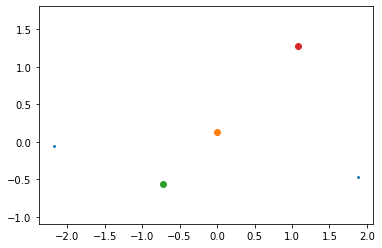

In [70]:
numberOfSims = 1 
endTime = 100 #years of simulation
ttor_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.time()
# try:
#     a = int(sys.argv[1])
# except IndexError:
#     print("#"*40)
#     print("\n"*3)
#     print("Sys.argv had an error! Setting the seed equal to 0!")
#     print("\n"*3)
#     print("#"*40)
a = 0
#
#for a in range(numberOfSims):
print("Beginning seed {}.".format(a))
sim = generatettor(simulation = ttor, seed =a, asteroidnumber = 2)
quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = 100)
ps = sim.particles
print("Masses {} and {}.".format(ps[1].m,ps[2].m))
print("Ending seed {}.\n".format(a))
pre_list = [ps[1].m, ps[2].m,a]
ttor_masses.append(pre_list)
#
BIGfinal = tiempo.time()
totaltime = BIGfinal - BIGinitial
print("That in total took {} seconds ({} minutes).".format(int(totaltime), \
                                                           round(totaltime/60,2)))
#masslist_txt(ttor_masses,'test.txt','ttor','w')
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))
#ding()
# try:
# 	if int(sys.argv[2]): # sys.argv=0 will mean this is the first data point, =1 is last
# 		first = False
# 		last = True
# 	else: 
# 		first = True
# 		last = False
# except IndexError: # if first or last not specified, it is a middle data point
# 	first = False
# 	last = False
first = False
last = False
#masslist_txt_append(ttor_masses,'Masslists/shortTests.txt','ttor','a', first = first, last = last)
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))

#saveFigs(addOn = "test", seed = a)

In [71]:
asteroidAU

array([[1.85858814, 1.9824141 ],
       [1.85299895, 1.98404746],
       [1.84942016, 1.98878654],
       [1.85264615, 1.98706733],
       [1.85801762, 1.97696938],
       [1.86182838, 2.01223722],
       [1.85206536, 2.01047775],
       [1.81066615, 2.0077829 ],
       [2.26204765, 2.00961597],
       [2.27214531, 2.01272687],
       [2.27237278, 2.00261121],
       [2.28199108, 1.96793171],
       [2.28407896, 1.98445628],
       [2.28359407, 1.97975809],
       [2.28074675, 1.97695015],
       [2.27880668, 1.97881685],
       [2.27910961, 1.98228042],
       [2.2804637 , 1.9822119 ],
       [2.32235515, 1.9470846 ],
       [2.32782208, 2.02773231],
       [2.32787088, 2.02853362],
       [2.33133916, 2.02674389],
       [2.32521115, 2.02677758],
       [2.32217086, 2.02834696],
       [2.32200122, 2.02733605],
       [2.32603122, 1.98831512],
       [2.32700199, 2.00263544],
       [2.32708546, 2.00111728],
       [2.32549269, 1.99720308],
       [2.31551223, 1.99600153],
       [2.

Text(0, 0.5, 'dist (AU)')

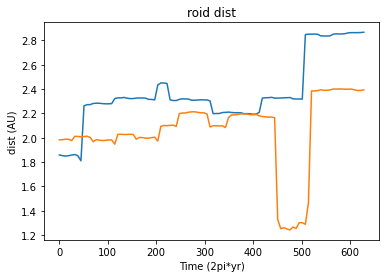

In [72]:
plt.clf()
plt.plot(times, asteroidAU)
plt.title('roid dist')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('dist (AU)')

In [51]:
sim.particles['1002']

<rebound.particle.Particle object at 0x7fe4712a66c0, m=0.0 x=0.46128903924994386 y=-0.591380569597873 z=0.0 vx=0.9104674235901148 vy=0.7101833653104964 vz=0.0>

In [46]:
sim.remove(hash = "innerPlanet")


(<Figure size 576x576 with 3 Axes>,
 <AxesSubplot:xlabel='x', ylabel='y'>,
 <matplotlib.axes._axes.Axes at 0x7fe472629310>)

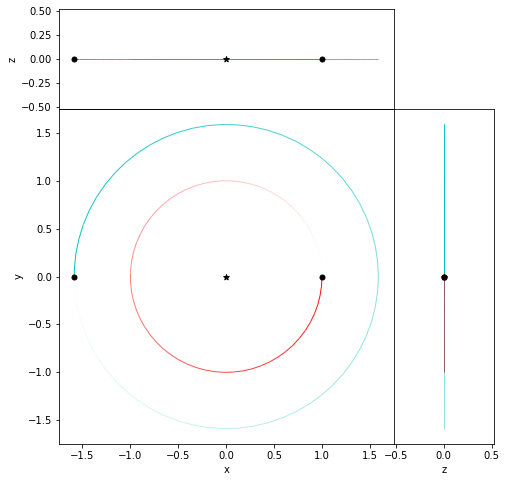

In [39]:
#rebound.OrbitPlot(sim,slices=0.3,color=True)
rebound.OrbitPlot(sim, slices = .3, color = True, lw = 1, plotparticles = [1,2])

Text(0, 0.5, 'sim.N (AU)')

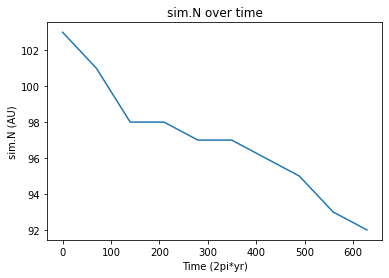

In [43]:
plt.clf()
plt.plot(times, particleNumber)
plt.title('sim.N over time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('sim.N (AU)')
plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")

In [52]:
min(5,2)

2